In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import analysis
from xgboost import XGBRegressor

In [4]:
df = pd.read_csv("Files/data.csv")
df.head(5)

,Titles,Price,Location,Rooms,Areas,Bathrooms,Listing Type,Useful area,Gross area,Construction year,Energetic certificate,Enterprise,Neighborhood,City,State
0,Apartamento T2+1 c/ Lugar de Garagem e Arrumo ...,260000.0,"Mafamude e Vilar do Paraíso, Vila Nova de Gaia...",3,106.00,2,Usado,106.00,121.0,2001,C,0,Mafamude e Vilar do Paraíso,Vila Nova de Gaia,Porto
1,Apartamento T1 para venda na Praia da Rocha,185000.0,"Portimão, Faro",1,58.30,1,Usado,58.30,68.3,2001,D,0,Portimão,Faro,NaN
2,"Apartamento T4, 2 Suítes, Luxo, Fonte Nova, Av...",950000.0,"Glória e Vera Cruz, Aveiro",4,175.00,4,Em construção,175.00,245.0,2023,A+,1,Glória e Vera Cruz,Aveiro,NaN
3,Apartamento T4,780000.0,"Vila do Conde, Porto",4,181.65,0,Em construção,181.65,207.9,0,B,1,Vila do Conde,Porto,NaN
4,Venda de Apartamento T3 duplex no centro de Vi...,300000.0,"Vila do Conde, Porto",3,183.00,2,NaN,183.00,183.0,0,D,0,Vila do Conde,Porto,NaN


In [5]:
df.describe()

,Price,Rooms,Areas,Bathrooms,Useful area,Gross area,Construction year,Enterprise
count,8.872800e+04,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,9.000000e+04,90000.000000
mean,4.066985e+05,2.351789,140.270821,1.804111,140.270776,177.082422,1.134178e+03,0.103700
std,4.375302e+05,1.001588,3182.582161,0.991427,3182.582162,4361.001389,6.838149e+03,0.304873
min,1.000000e+00,0.000000,0.110000,0.000000,0.110000,1.000000,0.000000e+00,0.000000
25%,2.070000e+05,2.000000,75.000000,1.000000,75.000000,83.000000,0.000000e+00,0.000000
50%,2.990000e+05,2.000000,100.000000,2.000000,100.000000,114.800000,1.981000e+03,0.000000
75%,4.558000e+05,3.000000,130.000000,2.000000,130.000000,153.000000,2.022000e+03,0.000000
max,3.600000e+07,10.000000,831000.000000,4.000000,831000.000000,831000.000000,2.024247e+06,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Titles                 90000 non-null  object 
 1   Price                  88728 non-null  float64
 2   Location               90000 non-null  object 
 3   Rooms                  90000 non-null  int64  
 4   Areas                  90000 non-null  float64
 5   Bathrooms              90000 non-null  int64  
 6   Listing Type           62115 non-null  object 
 7   Useful area            90000 non-null  float64
 8   Gross area             90000 non-null  float64
 9   Construction year      90000 non-null  int64  
 10  Energetic certificate  89575 non-null  object 
 11  Enterprise             90000 non-null  int64  
 12  Neighborhood           90000 non-null  object 
 13  City                   89556 non-null  object 
 14  State                  59701 non-null  object 
dtypes:

In [7]:
# Check the number of unique values in the 'Energy_Certificate' column
unique_values_ec = df['Energetic certificate'].unique()
unique_values_lt = df['Listing Type'].unique()

# Print the unique values
print(unique_values_ec)
print(unique_values_lt)

['C' 'D' 'A+' 'B' 'B-' 'E' 'A' 'Isento / Em Trâmite' 'F' nan 'G']
['Usado' 'Em construção' nan 'Novo' 'Para recuperar' 'Ruína']


In [8]:
# Drop rows with prices over 1,000,000 and less than 10000
df = df[(df['Price'] <= 1000000) & (df['Price'] >= 10000)]

# Drop rows with areas over 400 and less than 5
df = df[(df['Areas'] <= 400) & (df['Areas'] >= 5)]

# Remove rows with construction year older than 2030
df = df[df['Construction year'] <= 2030]

# Treat NaN values in 'Listing Type' as 'Usado' (used)
df['Listing Type'].fillna('Usado', inplace=True)

# Replace 0 values in 'Construction year' with NaN
df['Construction year'] = df['Construction year'].replace(0, np.nan)

# Group by 'Listing Type' and fill NaN values with the mean construction year for each group
df['Construction year'] = df.groupby('Listing Type')['Construction year'].transform(lambda x: x.fillna(x.mean()))

# If there are still NaN values after group-wise imputation, fill them with the overall mean
df['Construction year'].fillna(df['Construction year'].mean(), inplace=True)

# Update 'Construction year' for properties labeled as 'Novo' or 'Em construção' and older than 2020
df.loc[((df['Listing Type'] == 'Novo') | (df['Listing Type'] == 'Em construção')) & (df['Construction year'] < 2020), 'Construction year'] = 0

# Treat used properties with construction year more than 2023 as 'Novo' (new)
df.loc[(df['Listing Type'] == 'Usado') & (df['Construction year'] > 2023), 'Listing Type'] = 'Novo'

# Exclude rows with 'Novo' and 'Construction year' = 0
df = df[~((df['Listing Type'] == 'Novo') & (df['Construction year'] == 0))]

# Remove rows with construction year less than 1800
df = df[df['Construction year'] >= 1800]



In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83926 entries, 0 to 89999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Titles                 83926 non-null  object 
 1   Price                  83926 non-null  float64
 2   Location               83926 non-null  object 
 3   Rooms                  83926 non-null  int64  
 4   Areas                  83926 non-null  float64
 5   Bathrooms              83926 non-null  int64  
 6   Listing Type           83926 non-null  object 
 7   Useful area            83926 non-null  float64
 8   Gross area             83926 non-null  float64
 9   Construction year      83926 non-null  float64
 10  Energetic certificate  83530 non-null  object 
 11  Enterprise             83926 non-null  int64  
 12  Neighborhood           83926 non-null  object 
 13  City                   83529 non-null  object 
 14  State                  56517 non-null  object 
dtypes: floa

c:\Users\willi\anaconda3\envs\gpu\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


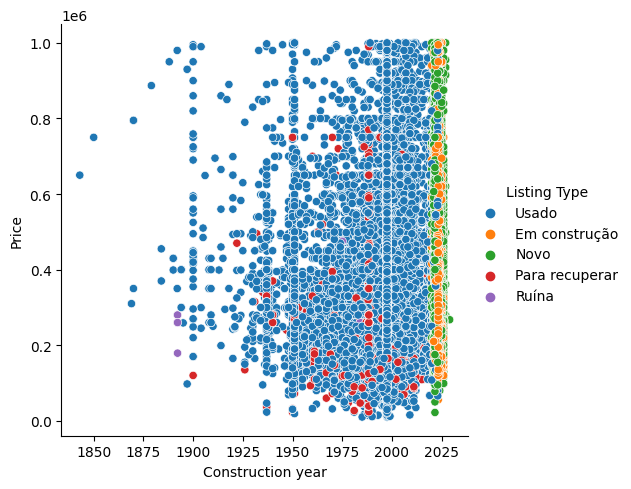

In [10]:
sns.relplot(data=df,x="Construction year", y="Price", hue="Listing Type")

In [11]:
# Fill NaN values with a default value (for example, 'Default Value')
df['Energetic certificate'].fillna('Default Value', inplace=True)

# Map the values to their numeric equivalents
certificate_mapping = {'A+': 7, 'A': 6, 'B+': 5, 'B': 4, 'B-': 3, 'C': 2, 'D': 1, 'E': 0, 'F': -1, 'G': -2, 'Isento / Em Trâmite': -3, 'Default Value': -4}

# Apply the mapping to the DataFrame
df['Energetic certificate'] = df['Energetic certificate'].map(certificate_mapping)

In [12]:
from sklearn.preprocessing import LabelEncoder

# Assuming your DataFrame is named 'df'
# Instantiate the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'Listing Type' column to numeric values
df['Listing Type'] = label_encoder.fit_transform(df['Listing Type'])

In [13]:
df.head(5)

,Titles,Price,Location,Rooms,Areas,Bathrooms,Listing Type,Useful area,Gross area,Construction year,Energetic certificate,Enterprise,Neighborhood,City,State
0,Apartamento T2+1 c/ Lugar de Garagem e Arrumo ...,260000.0,"Mafamude e Vilar do Paraíso, Vila Nova de Gaia...",3,106.00,2,4,106.00,121.0,2001.000000,2,0,Mafamude e Vilar do Paraíso,Vila Nova de Gaia,Porto
1,Apartamento T1 para venda na Praia da Rocha,185000.0,"Portimão, Faro",1,58.30,1,4,58.30,68.3,2001.000000,1,0,Portimão,Faro,NaN
2,"Apartamento T4, 2 Suítes, Luxo, Fonte Nova, Av...",950000.0,"Glória e Vera Cruz, Aveiro",4,175.00,4,0,175.00,245.0,2023.000000,7,1,Glória e Vera Cruz,Aveiro,NaN
3,Apartamento T4,780000.0,"Vila do Conde, Porto",4,181.65,0,0,181.65,207.9,2023.274565,4,1,Vila do Conde,Porto,NaN
4,Venda de Apartamento T3 duplex no centro de Vi...,300000.0,"Vila do Conde, Porto",3,183.00,2,4,183.00,183.0,1997.501664,1,0,Vila do Conde,Porto,NaN


**Creating features**

In [14]:
# Create the Square meter per room feature
df['Square Meter per Room'] = ((df['Areas'] / df['Rooms']).replace([np.inf, -np.inf], np.nan)).round(2)

# Create the Square meter per bathroom feature
df['Square Meter per Bathroom'] = ((df['Areas'] / df['Bathrooms']).replace([np.inf, -np.inf], np.nan)).round(2)

# Replace NaN values with 0 in the 'Square_Meter_per_Room' and 'Square_Meter_per_Bathroom' columns
df['Square Meter per Room'].fillna(0, inplace=True)
df['Square Meter per Bathroom'].fillna(0, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83926 entries, 0 to 89999
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Titles                     83926 non-null  object 
 1   Price                      83926 non-null  float64
 2   Location                   83926 non-null  object 
 3   Rooms                      83926 non-null  int64  
 4   Areas                      83926 non-null  float64
 5   Bathrooms                  83926 non-null  int64  
 6   Listing Type               83926 non-null  int32  
 7   Useful area                83926 non-null  float64
 8   Gross area                 83926 non-null  float64
 9   Construction year          83926 non-null  float64
 10  Energetic certificate      83926 non-null  int64  
 11  Enterprise                 83926 non-null  int64  
 12  Neighborhood               83926 non-null  object 
 13  City                       83529 non-null  object 


**Creating dummies for locations features**

In [15]:
from sklearn.preprocessing import LabelEncoder

# Fill missing Listing Type with 'Usado' (used)
df['Listing Type'].fillna('Usado', inplace=True)

# Perform one-hot encoding using get_dummies
df = pd.get_dummies(df, columns=['Listing Type'])

# Label encoding using LabelEncoder
le = LabelEncoder()
df['Neighborhood_Encoded'] = le.fit_transform(df['Neighborhood'])
df['City_Encoded'] = le.fit_transform(df['City'])
df['State_Encoded'] = le.fit_transform(df['State'])

# Dropping the original categorical columns
df.drop(['Neighborhood', 'City', 'State'], axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83926 entries, 0 to 89999
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Titles                     83926 non-null  object 
 1   Price                      83926 non-null  float64
 2   Location                   83926 non-null  object 
 3   Rooms                      83926 non-null  int64  
 4   Areas                      83926 non-null  float64
 5   Bathrooms                  83926 non-null  int64  
 6   Useful area                83926 non-null  float64
 7   Gross area                 83926 non-null  float64
 8   Construction year          83926 non-null  float64
 9   Energetic certificate      83926 non-null  int64  
 10  Enterprise                 83926 non-null  int64  
 11  Square Meter per Room      83926 non-null  float64
 12  Square Meter per Bathroom  83926 non-null  float64
 13  Listing Type_0             83926 non-null  bool   


**Train and test split**

In [16]:
from sklearn.model_selection import train_test_split

# Defining features and target variable
X = df.drop(columns=['Price', 'City_Encoded', 'State_Encoded', "Location", "Titles"])  
y = df['Price']  

# Get 60% of the dataset as the training set. Put the remaining 40% in temporary variables: x_ and y_.
X_train, x_, y_train, y_ = train_test_split(X, y, test_size=0.40, random_state=98)

# Split the 40% subset above into two: one half for cross validation and the other for the test set
X_cv, X_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.50, random_state=98)

# Display the shapes of the resulting sets to verify the split
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("X_test shape:", X_cv.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("y_train shape:", y_cv.shape)

X_train shape: (50355, 16)
X_test shape: (16786, 16)
X_test shape: (16785, 16)
y_train shape: (50355,)
y_test shape: (16786,)
y_train shape: (16785,)


**Standarlizing features**

In [17]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Scale the features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_cv_scaled = scaler.transform(X_cv)

In [24]:
y_train.shape

(50355,)

In [55]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'alpha': [0, 1, 5],
    'lambda': [0, 1, 5]
}

# Initialize XGBoost regressor
xgb_model = XGBRegressor(random_state=98)

# Initialize GridSearchCV
grid_search = GridSearchCV(xgb_model, param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit the model with hyperparameter tuning
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Create and train the XGBoost model with the best parameters
best_xgb_model = XGBRegressor(**best_params, verbosity=1, random_state=98)
best_xgb_model.fit(X_train_scaled, y_train, early_stopping_rounds=10, eval_metric="rmse", eval_set=[(X_train_scaled, y_train)])


[0]	validation_0-rmse:172279.45805
[1]	validation_0-rmse:160924.05028
[2]	validation_0-rmse:152708.95150
[3]	validation_0-rmse:146358.52069
[4]	validation_0-rmse:141466.27084
[5]	validation_0-rmse:137670.53314
[6]	validation_0-rmse:134061.05919
[7]	validation_0-rmse:131342.93609
[8]	validation_0-rmse:129331.97743
[9]	validation_0-rmse:127600.26562
[10]	validation_0-rmse:125471.33244
[11]	validation_0-rmse:123440.95765
[12]	validation_0-rmse:121911.02974
[13]	validation_0-rmse:120228.17359
[14]	validation_0-rmse:118966.06835
[15]	validation_0-rmse:117684.60492
[16]	validation_0-rmse:115282.06900
[17]	validation_0-rmse:112959.62495
[18]	validation_0-rmse:111737.55355
[19]	validation_0-rmse:110559.38019
[20]	validation_0-rmse:109704.96262
[21]	validation_0-rmse:108762.46005
[22]	validation_0-rmse:107231.94079


c:\Users\willi\anaconda3\envs\gpu\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\willi\anaconda3\envs\gpu\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-rmse:106193.24887
[24]	validation_0-rmse:105362.56274
[25]	validation_0-rmse:104763.58350
[26]	validation_0-rmse:104171.71311
[27]	validation_0-rmse:103847.11742
[28]	validation_0-rmse:103326.91935
[29]	validation_0-rmse:102911.47554
[30]	validation_0-rmse:102788.90120
[31]	validation_0-rmse:102439.23368
[32]	validation_0-rmse:101865.86002
[33]	validation_0-rmse:101475.95786
[34]	validation_0-rmse:101113.32605
[35]	validation_0-rmse:101043.83310
[36]	validation_0-rmse:100688.66448
[37]	validation_0-rmse:99417.06762
[38]	validation_0-rmse:98539.84079
[39]	validation_0-rmse:98211.33849
[40]	validation_0-rmse:97767.71259
[41]	validation_0-rmse:97702.43580
[42]	validation_0-rmse:97069.50981
[43]	validation_0-rmse:96476.76531
[44]	validation_0-rmse:96032.79058
[45]	validation_0-rmse:95538.60603
[46]	validation_0-rmse:95028.11767
[47]	validation_0-rmse:94785.77260
[48]	validation_0-rmse:94602.27211
[49]	validation_0-rmse:94541.64477
[50]	validation_0-rmse:93928.67095
[51]	v

XGBRegressor(alpha=5, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=5, learning_rate=0.2,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None, ...)

In [48]:
# Create and train the XGBoost model
xgb_model = XGBRegressor(n_estimators=2000, learning_rate=0.1, verbosity=1, random_state=98)
xgb_model.fit(X_train_scaled, y_train, early_stopping_rounds=10, eval_metric="rmse", eval_set=[(X_train_scaled, y_train)])

[0]	validation_0-rmse:179974.49958
[1]	validation_0-rmse:173569.22280
[2]	validation_0-rmse:168223.53922
[3]	validation_0-rmse:163724.27403


[4]	validation_0-rmse:159637.86577
[5]	validation_0-rmse:156253.11085
[6]	validation_0-rmse:153179.15995
[7]	validation_0-rmse:150501.66825
[8]	validation_0-rmse:148162.26091
[9]	validation_0-rmse:145966.84107
[10]	validation_0-rmse:144081.35793
[11]	validation_0-rmse:142472.48151
[12]	validation_0-rmse:141085.67643
[13]	validation_0-rmse:139816.58061
[14]	validation_0-rmse:138568.84002
[15]	validation_0-rmse:137368.19061
[16]	validation_0-rmse:136248.87344
[17]	validation_0-rmse:135070.68634
[18]	validation_0-rmse:134045.10018
[19]	validation_0-rmse:132624.47490
[20]	validation_0-rmse:131812.33523
[21]	validation_0-rmse:130872.40754
[22]	validation_0-rmse:129832.90650


c:\Users\willi\anaconda3\envs\gpu\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\willi\anaconda3\envs\gpu\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-rmse:129217.72105
[24]	validation_0-rmse:128382.87627
[25]	validation_0-rmse:127540.35004
[26]	validation_0-rmse:127035.70212
[27]	validation_0-rmse:126406.15274
[28]	validation_0-rmse:125719.34029
[29]	validation_0-rmse:124914.02675
[30]	validation_0-rmse:123855.51160
[31]	validation_0-rmse:123376.28643
[32]	validation_0-rmse:122782.65432
[33]	validation_0-rmse:122349.52720
[34]	validation_0-rmse:121872.35088
[35]	validation_0-rmse:121417.10691
[36]	validation_0-rmse:120841.57174
[37]	validation_0-rmse:120552.70574
[38]	validation_0-rmse:119412.04275
[39]	validation_0-rmse:118906.21904
[40]	validation_0-rmse:118541.07576
[41]	validation_0-rmse:117939.86042
[42]	validation_0-rmse:117612.71436
[43]	validation_0-rmse:117250.94368
[44]	validation_0-rmse:116286.67948
[45]	validation_0-rmse:115970.80640
[46]	validation_0-rmse:115455.36984
[47]	validation_0-rmse:115006.64635
[48]	validation_0-rmse:114736.61380
[49]	validation_0-rmse:114275.70092
[50]	validation_0-rmse:11390

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, random_state=98, ...)

In [61]:
predictions_train = best_xgb_model.predict(X_train_scaled)
predictions_cv = best_xgb_model.predict(X_cv_scaled)
predictions_test = best_xgb_model.predict(X_test_scaled)

In [63]:
# Analyse Train predictions
analysis.evaluate_model_performance(y_cv, predictions_cv)

{'MAE': 53289.272153569036,
 'MSE': 7166832068.711995,
 'RMSE': 84657.14422724166,
 'R2': 0.7978154681836914}

In [62]:
# Analyse CV predictions
analysis.evaluate_model_performance(y_test, predictions_test)

{'MAE': 53740.117461180096,
 'MSE': 7266736994.95738,
 'RMSE': 85245.15819069948,
 'R2': 0.7929537393814832}

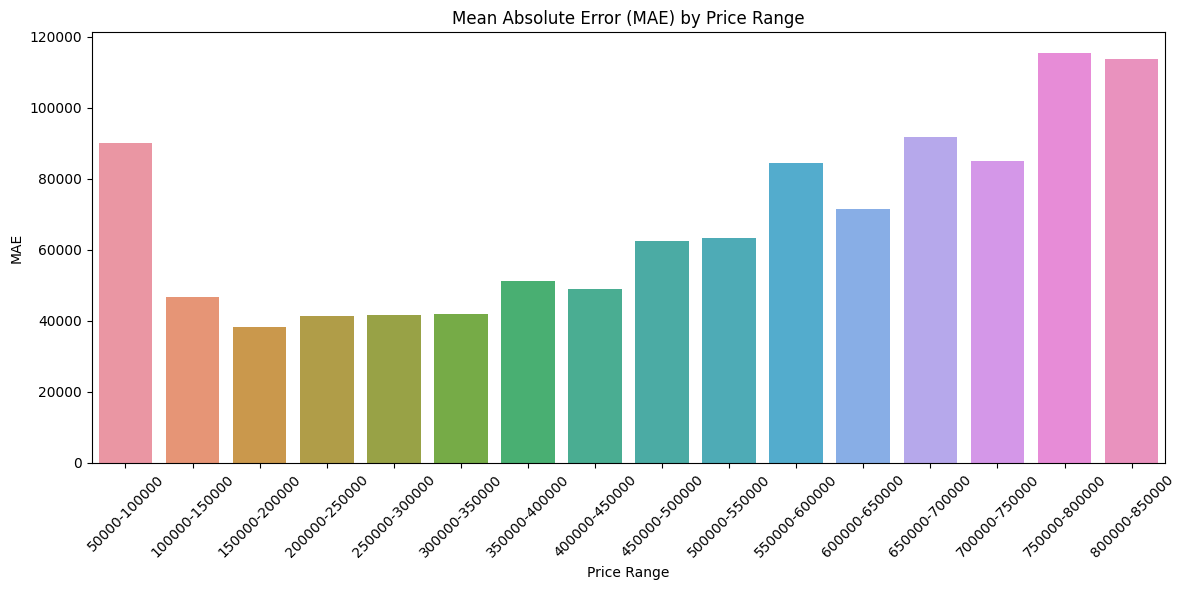

c:\Users\willi\Documents\GitHub\Predict-apartment-price-Project\Main\analysis.py:71: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test, label='Actual Values', color='blue', shade=True)
c:\Users\willi\Documents\GitHub\Predict-apartment-price-Project\Main\analysis.py:72: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(predictions, label='Predicted Values', color='red', shade=True)


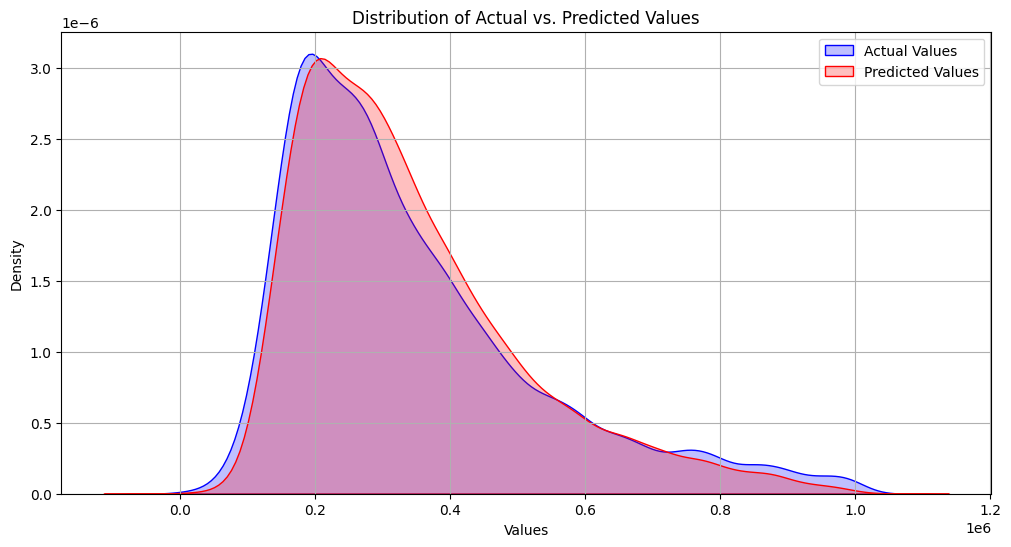

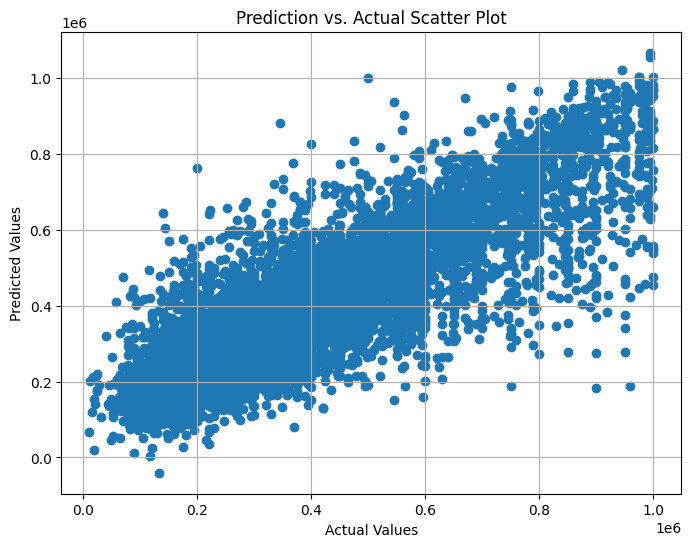

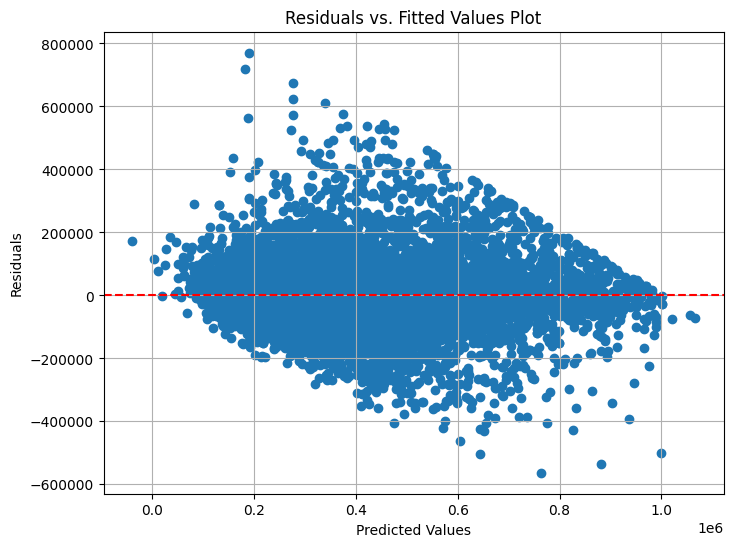

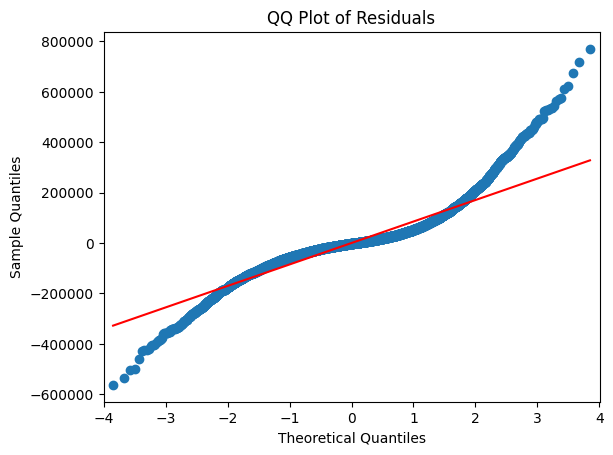

In [69]:
# Call the modified analyze_precision function
analysis.analyze_precision(X_test, y_test, predictions_test)